# **Bootstrapping of Dictionaries** 

## **Document Level, non clipped**

In [1]:
# packages
!pip install sentence-transformers==2.2.2
!pip install huggingface_hub==0.25.1

!pip install wordcloud
!pip install adjustText

  Using cached sentence_transformers-2.2.2-py3-none-any.whl
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 745.4 kB/s eta 0:00:000:01
  Using cached torch-2.7.1-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (29 kB)
  Using cached torchvision-0.22.1-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (6.1 kB)
  Using cached nltk-3.9.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached sentencepiece-0.2.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.7 kB)
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached hf_xet-1.1.5-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (879 bytes)
  Using cached typing_extensions-4.14.1-py3-none-any.whl.metadata (3.0 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.6.77-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.6.77-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl

In [4]:
import pandas as pd
import random
import numpy as np
from tqdm import tqdm

from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import json
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as patches

from sklearn.feature_extraction.text import TfidfVectorizer
import math
from adjustText import adjust_text
from scipy.stats import pearsonr
from numpy import linalg as LA
from scipy.stats import zscore
import zipfile
from sklearn.model_selection import train_test_split


## Models and Dictionaries

In [28]:
# import models

# AFTER POOL

finetuned_model = SentenceTransformer('../00_embedding_models/after_pool_finetuned_sentence_model_wordlim_10_window_5')
self_build_model = SentenceTransformer('../00_embedding_models/after_pool_self_build_sentence_model_wordlim_10_window_5')

# import dictionaries
evidence = pd.read_csv("../dictionaries_emi/evidence_lexicon.csv")
intuition = pd.read_csv("../dictionaries_emi/intuition_lexicon.csv")


In [29]:
# Get embeddings for dictionary words

finetuned_evidence_embeddings = finetuned_model.encode(evidence['evidence_keywords'])
finetuned_intuition_embeddings = finetuned_model.encode(intuition['intuition_keywords'])

self_evidence_embeddings = self_build_model.encode(evidence['evidence_keywords'])
self_intuition_embeddings = self_build_model.encode(intuition['intuition_keywords'])


In [30]:

# their norm
evidence_norms_ft = np.linalg.norm(finetuned_evidence_embeddings, axis=1)
intuition_norms_ft = np.linalg.norm(finetuned_intuition_embeddings, axis=1)

evidence_norms_sb = np.linalg.norm(self_evidence_embeddings, axis=1)
intuition_norms_sb = np.linalg.norm(self_intuition_embeddings, axis=1)


# z-scores
evidence_zscores_ft = zscore(evidence_norms_ft)
intuition_zscores_ft = zscore(intuition_norms_ft)

evidence_zscores_sb = zscore(evidence_norms_sb)
intuition_zscores_sb = zscore(intuition_norms_sb)


# Make df
df_evidence = pd.DataFrame({
    "word": evidence['evidence_keywords'],
    "embedding_ft": list(finetuned_evidence_embeddings), 
    "embedding_sb": list(self_evidence_embeddings), 
    "norm_ft": evidence_norms_ft,
    "norm_sb": evidence_norms_sb,
    "z-score_ft": evidence_zscores_ft,
    "z-score_sb": evidence_zscores_sb
})


df_intuition = pd.DataFrame({
    "word": intuition['intuition_keywords'],
    "embedding_ft": list(finetuned_intuition_embeddings), 
    "embedding_sb": list(self_intuition_embeddings), 
    "norm_ft": intuition_norms_ft,
    "norm_sb": intuition_norms_sb,
    "z-score_ft": intuition_zscores_ft,
    "z-score_sb": intuition_zscores_sb
})


In [6]:
df_evidence
#df_intuition

,word,embedding_ft,embedding_sb,norm_ft,norm_sb,z-score_ft,z-score_sb
0,accurate,"[-0.07633275, -0.11705223, -0.094368055, 0.006...","[-0.020695282, 0.07546731, -0.10320894, -0.033...",1.0,1.0,-1.649916,0.000000
1,analyse,"[-0.011831486, -0.024427377, -0.0051206592, 0....","[-0.030805515, -0.040031154, -0.08503759, -0.0...",1.0,1.0,0.000000,0.000000
2,analysis,"[0.0039203446, -0.014852947, 0.023248818, 0.02...","[-0.03762376, 0.032084078, -0.03233184, -0.100...",1.0,1.0,-1.649916,0.000000
3,correct,"[-0.0966623, -0.08371393, -0.05452827, 0.00539...","[0.039523017, 0.026090413, -0.046577457, 0.000...",1.0,1.0,0.000000,-2.110579
4,correction,"[0.036097363, -0.0025274577, 0.079878196, -0.0...","[0.03978918, -0.019495297, 0.010020363, -0.111...",1.0,1.0,0.000000,-2.110579
5,data,"[-0.04315679, -0.082168505, -0.10087393, 0.052...","[-0.078547694, -0.03939558, -0.08206244, -0.00...",1.0,1.0,-1.649916,0.000000
6,dossier,"[-0.040630437, 0.07168719, -0.040785927, -0.01...","[0.0012046405, 0.06859794, 0.03353569, 0.09652...",1.0,1.0,0.000000,0.000000
7,education,"[0.040275365, -0.042782947, 0.061504137, 0.040...","[0.0019918603, 0.052030995, -0.018174289, -0.0...",1.0,1.0,0.000000,0.000000
8,evidence,"[0.015212556, -0.01919913, -0.058649577, 0.016...","[-0.12124397, 0.11885475, -0.018625965, -0.019...",1.0,1.0,0.000000,-2.110579
9,evident,"[-0.05033586, -0.04429693, 0.06724591, 0.07282...","[0.039442338, 0.102390856, 0.027916148, -0.007...",1.0,1.0,0.000000,-2.110579


In [31]:
# this needs to be randomized

# mean of word embeddings, then normalize --> concept embedding

evidence_dim_ft = df_evidence['embedding_ft'].mean(axis = 0) / LA.norm(df_evidence['embedding_ft'].mean(axis = 0))
intuition_dim_ft = df_intuition['embedding_ft'].mean(axis = 0) / LA.norm(df_intuition['embedding_ft'].mean(axis = 0))

evidence_dim_sb = df_evidence['embedding_sb'].mean(axis = 0) / LA.norm(df_evidence['embedding_sb'].mean(axis = 0))
intuition_dim_sb = df_intuition['embedding_sb'].mean(axis = 0) / LA.norm(df_intuition['embedding_sb'].mean(axis = 0))

## Bootstrap Dictionaries

In [32]:
# generate random lengths

np.random.seed(23)
random_dict_length_e = np.random.randint(low = 30, high = (len(df_evidence)), size = 1000)
random_dict_length_i = np.random.randint(low = 30, high = (len(df_intuition)), size = 1000)

In [33]:
random_dict_length_e

array([36, 38, 39, 38, 43, 42, 37, 36, 43, 42, 47, 32, 41, 35, 30, 42, 46,
       39, 45, 31, 37, 45, 34, 31, 31, 41, 45, 37, 32, 40, 42, 33, 30, 43,
       36, 44, 30, 36, 30, 32, 30, 44, 44, 46, 36, 32, 48, 41, 40, 37, 40,
       35, 36, 34, 41, 38, 30, 34, 41, 31, 39, 35, 39, 37, 47, 30, 33, 40,
       40, 36, 34, 30, 48, 31, 38, 32, 34, 30, 41, 34, 30, 47, 44, 39, 35,
       36, 35, 37, 34, 46, 36, 39, 46, 45, 41, 47, 36, 32, 30, 45, 30, 46,
       45, 32, 32, 40, 32, 38, 31, 44, 46, 36, 36, 32, 43, 36, 40, 33, 40,
       33, 47, 39, 31, 46, 47, 47, 36, 41, 34, 41, 46, 33, 33, 37, 40, 48,
       46, 37, 31, 38, 47, 36, 34, 40, 47, 33, 48, 40, 47, 30, 39, 36, 39,
       30, 43, 34, 32, 47, 31, 39, 33, 43, 48, 46, 32, 33, 33, 42, 35, 47,
       30, 34, 34, 38, 30, 43, 33, 40, 33, 39, 43, 47, 33, 36, 37, 37, 39,
       45, 39, 46, 40, 31, 47, 46, 39, 46, 46, 46, 45, 38, 39, 33, 35, 46,
       45, 37, 45, 40, 47, 37, 43, 35, 38, 33, 34, 43, 38, 46, 38, 36, 37,
       33, 45, 34, 33, 43

In [34]:
# sample my 1000 evidence and intuition dictionaries of the random lengths

rand_dict_e = {}
for idx, rand_len in enumerate(random_dict_length_e):

    rand_dict_e[idx] = df_evidence.sample(rand_len, random_state = 23).reset_index(drop = True) 



rand_dict_i = {}
for idx, rand_len in enumerate(random_dict_length_i):

    rand_dict_i[idx] = df_intuition.sample(rand_len, random_state = 23).reset_index(drop = True) 

    

In [35]:
# calculate random e and i dimensions (average random dict-words embeddings)

rand_e_dim = {}
for idx, rand_df in rand_dict_e.items():

    rand_e_dim[idx] = {}
    
    rand_e_dim[idx]['evidence_dim_ft'] = rand_df['embedding_ft'].mean(axis = 0) / LA.norm(rand_df['embedding_ft'].mean(axis = 0))
    rand_e_dim[idx]['evidence_dim_sb'] = rand_df['embedding_sb'].mean(axis = 0) / LA.norm(rand_df['embedding_sb'].mean(axis = 0))

   

rand_i_dim = {}
for idx, rand_df in rand_dict_i.items():

    rand_i_dim[idx] = {}
    
    rand_i_dim[idx]['intuition_dim_ft'] = rand_df['embedding_ft'].mean(axis = 0) / LA.norm(rand_df['embedding_ft'].mean(axis = 0))
    rand_i_dim[idx]['intuition_dim_sb'] = rand_df['embedding_sb'].mean(axis = 0) / LA.norm(rand_df['embedding_sb'].mean(axis = 0))


    
    

## Import Documents

* Import all subreddits
* From each subreddit, get unique texts (unique com, rep, sub)
* Embedd only unique texts

In [13]:
test = pd.read_csv(f"output_non_clipped/Askpolitics_emb.csv")
test.columns

# averaging word embeddings --> word embeddings are technically normalizes (due to post-pool-model)
# For consistency: need to rerun embeddings of subreddits_reduced to save the embedding vectors (using non-normalizes word embeddings)

Index(['msg_id_parent', 'msg_id_child', 'submission_id', 'subreddit',
       'exact_time_child', 'author_child', 'author_parent',
       'author_submission', 'parent_tokens', 'parent_len', 'child_tokens',
       'child_len', 'submission_tokens', 'submission_len',
       'finetuned_parent_E_emb', 'finetuned_parent_I_emb',
       'finetuned_child_E_emb', 'finetuned_child_I_emb',
       'finetuned_submission_E_emb', 'finetuned_submission_I_emb',
       'self_parent_E_emb', 'self_parent_I_emb', 'self_child_E_emb',
       'self_child_I_emb', 'self_submission_E_emb', 'self_submission_I_emb',
       'finetuned_parent_E', 'finetuned_parent_I', 'finetuned_child_E',
       'finetuned_child_I', 'finetuned_submission_E', 'finetuned_submission_I',
       'self_parent_E', 'self_parent_I', 'self_child_E', 'self_child_I',
       'self_submission_E', 'self_submission_I'],
      dtype='object')

In [19]:
for i in range(1, 10):
    
    print(i)

1
2
3
4
5
6
7
8
9


In [20]:
subreddits = ["Ask_Politics", "Askpolitics", "PoliticalDebate", "PoliticalDiscussion", "NeutralPolitics", "politics"]

unique_texts_all = pd.DataFrame()

for subr in subreddits:

    if subr == "politics":
        
        df = pd.DataFrame()
        for i in range(1, 10):
            df_temp = pd.read_csv(f"output_non_clipped/politics_{i}_emb.csv")[['msg_id_parent', 'msg_id_child', 'submission_id', 
                                                            'subreddit', 'finetuned_parent_E_emb', 'finetuned_parent_I_emb',
                                                            'finetuned_child_E_emb', 'finetuned_child_I_emb',
                                                            'finetuned_submission_E_emb', 'finetuned_submission_I_emb',
                                                            'self_parent_E_emb', 'self_parent_I_emb', 'self_child_E_emb',
                                                            'self_child_I_emb', 'self_submission_E_emb', 'self_submission_I_emb']]
            df = pd.concat([df, df_temp]).reset_index(drop = True)
            print("Done with politics")

    else:
        df = pd.read_csv(f"output_non_clipped/{subr}_emb.csv")[['msg_id_parent', 'msg_id_child', 'submission_id', 
                                                        'subreddit', 'finetuned_parent_E_emb', 'finetuned_parent_I_emb',
                                                        'finetuned_child_E_emb', 'finetuned_child_I_emb',
                                                        'finetuned_submission_E_emb', 'finetuned_submission_I_emb',
                                                        'self_parent_E_emb', 'self_parent_I_emb', 'self_child_E_emb',
                                                        'self_child_I_emb', 'self_submission_E_emb', 'self_submission_I_emb']]
    
    
    comments_df = df[['subreddit', 'msg_id_parent', 'finetuned_parent_E_emb', 'finetuned_parent_I_emb', 
                      'self_parent_E_emb','self_parent_I_emb']].dropna().drop_duplicates().copy()
    comments_df.columns = ['subreddit', 'id', 'finetuned_E_emb', 'finetuned_I_emb', 'self_E_emb', 'self_I_emb']
    comments_df['type'] = 'parent'
    
    
    
    replies_df = df[['subreddit', 'msg_id_child', 'finetuned_child_E_emb', 'finetuned_child_I_emb', 
                      'self_child_E_emb','self_child_I_emb']].dropna().drop_duplicates().copy()
    replies_df.columns = ['subreddit', 'id', 'finetuned_E_emb', 'finetuned_I_emb', 'self_E_emb', 'self_I_emb']
    replies_df['type'] = 'child'
    
    subs_df = df[['subreddit', 'submission_id', 'finetuned_submission_E_emb', 'finetuned_submission_I_emb', 
                      'self_submission_E_emb','self_submission_I_emb']].dropna().drop_duplicates().copy()
    subs_df.columns = ['subreddit', 'id', 'finetuned_E_emb', 'finetuned_I_emb', 'self_E_emb', 'self_I_emb']
    subs_df['type'] = 'submission'
    
    # Concatenate into one unified dataframe
    unique_text_df = pd.concat([comments_df, replies_df, subs_df], ignore_index=True)
    unique_texts_all = pd.concat([unique_texts_all, unique_text_df]).reset_index(drop = True)
    
    # Optional: remove exact duplicate texts (if you only want unique *text bodies*)
    #unique_text_df = unique_text_df.drop_duplicates(subset='text')

unique_texts_all

Done with politics
Done with politics
Done with politics
Done with politics
Done with politics
Done with politics
Done with politics


,subreddit,id,finetuned_E_emb,finetuned_I_emb,self_E_emb,self_I_emb,type
0,Ask_Politics,c7ecp8d,[-3.89609039e-02 -1.45731270e-01 -3.87618393e-...,[-3.89609039e-02 -1.45731270e-01 -3.87618393e-...,[-0.10344908 -0.13137741 -0.02859881 -0.078365...,[-0.10344908 -0.13137741 -0.02859881 -0.078365...,parent
1,Ask_Politics,c7efx8q,[-0.01144043 -0.09320187 -0.05126924 -0.045571...,[-0.01144043 -0.09320187 -0.05126924 -0.045571...,[-5.22156432e-02 -1.29565135e-01 -3.38422544e-...,[-5.22156432e-02 -1.29565135e-01 -3.38422544e-...,parent
2,Ask_Politics,c7edr13,[-0.1514677 -0.08389024 -0.05855702 0.031323...,[-0.1514677 -0.08389024 -0.05855702 0.031323...,[ 0.02760824 0.01997875 -0.05295471 -0.011017...,[ 0.02760824 0.01997875 -0.05295471 -0.011017...,parent
3,Ask_Politics,c7ee45j,[-0.07512397 -0.1114663 0.04122218 0.063893...,[-0.07512397 -0.1114663 0.04122218 0.063893...,[-0.01411831 0.01999405 0.00883848 0.017689...,[-0.01411831 0.01999405 0.00883848 0.017689...,parent
4,Ask_Politics,c7ejopx,[ 0.05579745 -0.04664776 -0.01142577 0.035338...,[ 0.05579745 -0.04664776 -0.01142577 0.035338...,[ 6.50477633e-02 -1.24112901e-03 -2.53487080e-...,[ 6.50477633e-02 -1.24112901e-03 -2.53487080e-...,parent
...,...,...,...,...,...,...,...
7039206,politics,18mfx16,[ 1.76615994e-02 -7.04686046e-02 -2.22658794e-...,[ 1.76615994e-02 -7.04686046e-02 -2.22658794e-...,[-6.53358102e-02 -1.20709181e-01 6.94107041e-...,[-6.53358102e-02 -1.20709181e-01 6.94107041e-...,submission
7039207,politics,18mfyba,[ 1.76615994e-02 -7.04686046e-02 -2.22658794e-...,[ 1.76615994e-02 -7.04686046e-02 -2.22658794e-...,[-6.53358102e-02 -1.20709181e-01 6.94107041e-...,[-6.53358102e-02 -1.20709181e-01 6.94107041e-...,submission
7039208,politics,18p9iet,[-0.03871411 -0.06474663 0.00493962 -0.001351...,[-0.03871411 -0.06474663 0.00493962 -0.001351...,[-0.02318155 -0.02290864 0.04275502 0.021226...,[-0.02318155 -0.02290864 0.04275502 0.021226...,submission
7039209,politics,18qmiau,[-3.16834189e-02 -1.24233253e-01 -1.99404769e-...,[-3.16834189e-02 -1.24233253e-01 -1.99404769e-...,[-1.55516602e-02 -6.31724671e-02 -1.17236115e-...,[-1.55516602e-02 -6.31724671e-02 -1.17236115e-...,submission


In [21]:
unique_texts_all_formatted = unique_texts_all.copy(deep = True)
unique_texts_all_formatted

,subreddit,id,finetuned_E_emb,finetuned_I_emb,self_E_emb,self_I_emb,type
0,Ask_Politics,c7ecp8d,[-3.89609039e-02 -1.45731270e-01 -3.87618393e-...,[-3.89609039e-02 -1.45731270e-01 -3.87618393e-...,[-0.10344908 -0.13137741 -0.02859881 -0.078365...,[-0.10344908 -0.13137741 -0.02859881 -0.078365...,parent
1,Ask_Politics,c7efx8q,[-0.01144043 -0.09320187 -0.05126924 -0.045571...,[-0.01144043 -0.09320187 -0.05126924 -0.045571...,[-5.22156432e-02 -1.29565135e-01 -3.38422544e-...,[-5.22156432e-02 -1.29565135e-01 -3.38422544e-...,parent
2,Ask_Politics,c7edr13,[-0.1514677 -0.08389024 -0.05855702 0.031323...,[-0.1514677 -0.08389024 -0.05855702 0.031323...,[ 0.02760824 0.01997875 -0.05295471 -0.011017...,[ 0.02760824 0.01997875 -0.05295471 -0.011017...,parent
3,Ask_Politics,c7ee45j,[-0.07512397 -0.1114663 0.04122218 0.063893...,[-0.07512397 -0.1114663 0.04122218 0.063893...,[-0.01411831 0.01999405 0.00883848 0.017689...,[-0.01411831 0.01999405 0.00883848 0.017689...,parent
4,Ask_Politics,c7ejopx,[ 0.05579745 -0.04664776 -0.01142577 0.035338...,[ 0.05579745 -0.04664776 -0.01142577 0.035338...,[ 6.50477633e-02 -1.24112901e-03 -2.53487080e-...,[ 6.50477633e-02 -1.24112901e-03 -2.53487080e-...,parent
...,...,...,...,...,...,...,...
7039206,politics,18mfx16,[ 1.76615994e-02 -7.04686046e-02 -2.22658794e-...,[ 1.76615994e-02 -7.04686046e-02 -2.22658794e-...,[-6.53358102e-02 -1.20709181e-01 6.94107041e-...,[-6.53358102e-02 -1.20709181e-01 6.94107041e-...,submission
7039207,politics,18mfyba,[ 1.76615994e-02 -7.04686046e-02 -2.22658794e-...,[ 1.76615994e-02 -7.04686046e-02 -2.22658794e-...,[-6.53358102e-02 -1.20709181e-01 6.94107041e-...,[-6.53358102e-02 -1.20709181e-01 6.94107041e-...,submission
7039208,politics,18p9iet,[-0.03871411 -0.06474663 0.00493962 -0.001351...,[-0.03871411 -0.06474663 0.00493962 -0.001351...,[-0.02318155 -0.02290864 0.04275502 0.021226...,[-0.02318155 -0.02290864 0.04275502 0.021226...,submission
7039209,politics,18qmiau,[-3.16834189e-02 -1.24233253e-01 -1.99404769e-...,[-3.16834189e-02 -1.24233253e-01 -1.99404769e-...,[-1.55516602e-02 -6.31724671e-02 -1.17236115e-...,[-1.55516602e-02 -6.31724671e-02 -1.17236115e-...,submission


In [22]:
# fix formatting of embedding vectors 


def fix_string_vector(s):
    if pd.isna(s):
        return np.array([])
    
    s = s.strip().replace('[', '').replace(']', '')
    
    # Replace all kinds of separators with single space
    s = re.sub(r'[,\s]+', ' ', s).strip()
    
    try:
        return np.fromstring(s, sep=' ')
    except:
        return np.array([])

# Apply to all embedding columns
embedding_cols = [col for col in unique_texts_all_formatted.columns if '_emb' in col]

for col in embedding_cols:
    unique_texts_all_formatted[col] = unique_texts_all_formatted[col].apply(fix_string_vector)



In [23]:
unique_texts_all_formatted

,subreddit,id,finetuned_E_emb,finetuned_I_emb,self_E_emb,self_I_emb,type
0,Ask_Politics,c7ecp8d,"[-0.0389609039, -0.14573127, -0.0387618393, -0...","[-0.0389609039, -0.14573127, -0.0387618393, -0...","[-0.10344908, -0.13137741, -0.02859881, -0.078...","[-0.10344908, -0.13137741, -0.02859881, -0.078...",parent
1,Ask_Politics,c7efx8q,"[-0.01144043, -0.09320187, -0.05126924, -0.045...","[-0.01144043, -0.09320187, -0.05126924, -0.045...","[-0.0522156432, -0.129565135, -0.0338422544, -...","[-0.0522156432, -0.129565135, -0.0338422544, -...",parent
2,Ask_Politics,c7edr13,"[-0.1514677, -0.08389024, -0.05855702, 0.03132...","[-0.1514677, -0.08389024, -0.05855702, 0.03132...","[0.02760824, 0.01997875, -0.05295471, -0.01101...","[0.02760824, 0.01997875, -0.05295471, -0.01101...",parent
3,Ask_Politics,c7ee45j,"[-0.07512397, -0.1114663, 0.04122218, 0.063893...","[-0.07512397, -0.1114663, 0.04122218, 0.063893...","[-0.01411831, 0.01999405, 0.00883848, 0.017689...","[-0.01411831, 0.01999405, 0.00883848, 0.017689...",parent
4,Ask_Politics,c7ejopx,"[0.05579745, -0.04664776, -0.01142577, 0.03533...","[0.05579745, -0.04664776, -0.01142577, 0.03533...","[0.0650477633, -0.00124112901, -0.025348708, -...","[0.0650477633, -0.00124112901, -0.025348708, -...",parent
...,...,...,...,...,...,...,...
7039206,politics,18mfx16,"[0.0176615994, -0.0704686046, -0.0222658794, -...","[0.0176615994, -0.0704686046, -0.0222658794, -...","[-0.0653358102, -0.120709181, 0.0694107041, -0...","[-0.0653358102, -0.120709181, 0.0694107041, -0...",submission
7039207,politics,18mfyba,"[0.0176615994, -0.0704686046, -0.0222658794, -...","[0.0176615994, -0.0704686046, -0.0222658794, -...","[-0.0653358102, -0.120709181, 0.0694107041, -0...","[-0.0653358102, -0.120709181, 0.0694107041, -0...",submission
7039208,politics,18p9iet,"[-0.03871411, -0.06474663, 0.00493962, -0.0013...","[-0.03871411, -0.06474663, 0.00493962, -0.0013...","[-0.02318155, -0.02290864, 0.04275502, 0.02122...","[-0.02318155, -0.02290864, 0.04275502, 0.02122...",submission
7039209,politics,18qmiau,"[-0.0316834189, -0.124233253, -0.0199404769, -...","[-0.0316834189, -0.124233253, -0.0199404769, -...","[-0.0155516602, -0.0631724671, -0.0117236115, ...","[-0.0155516602, -0.0631724671, -0.0117236115, ...",submission


**non clipped: here, should be all**
6332039 rows instead of 7035721 because some text don't habe pos E or pos I words --> clipping removed so nothing to encode: drop

In [24]:
# make a stratified dample

df_sample, df_test = train_test_split(unique_texts_all_formatted, test_size=0.95, stratify=unique_texts_all_formatted[["subreddit", "type"]])

In [25]:
print(len(df_sample))
df_sample['subreddit'].value_counts()

351960


subreddit
politics               289925
PoliticalDiscussion     51614
Ask_Politics             5411
NeutralPolitics          3546
PoliticalDebate           737
Askpolitics               727
Name: count, dtype: int64

In [36]:
doc_similarities_dict = {}

for doc_id in tqdm(df_sample["id"], desc="Processing words"):
    
    # take embeddings
    doc_E_emb_ft = df_sample.loc[df_sample["id"] == doc_id, 'finetuned_E_emb'].values[0]
    doc_I_emb_ft = df_sample.loc[df_sample["id"] == doc_id, 'finetuned_I_emb'].values[0]
    
    doc_E_emb_sb = df_sample.loc[df_sample["id"] == doc_id, 'self_E_emb'].values[0]
    doc_I_emb_sb = df_sample.loc[df_sample["id"] == doc_id, 'self_I_emb'].values[0]

    # make dict with both models: lists of cos-sim
    doc_similarities_dict[doc_id] = {
        'e_sim_ft': [],
        'e_sim_sb': [],
        'i_sim_ft': [],
        'i_sim_sb': []
    }
    
    # for each random evidence dimension
    for idx, e_dim in rand_e_dim.items():
        sim_ft = cosine_similarity(doc_E_emb_ft.reshape(1, -1), e_dim['evidence_dim_ft'].reshape(1, -1))[0][0]
        sim_sb = cosine_similarity(doc_E_emb_sb.reshape(1, -1), e_dim['evidence_dim_sb'].reshape(1, -1))[0][0]

        doc_similarities_dict[doc_id]['e_sim_ft'].append(sim_ft)
        doc_similarities_dict[doc_id]['e_sim_sb'].append(sim_sb)


    # for each random intuition dimension
    for idx, i_dim in rand_i_dim.items():
        sim_ft = cosine_similarity(doc_I_emb_ft.reshape(1, -1), i_dim['intuition_dim_ft'].reshape(1, -1))[0][0]
        sim_sb = cosine_similarity(doc_I_emb_sb.reshape(1, -1), i_dim['intuition_dim_sb'].reshape(1, -1))[0][0]

        doc_similarities_dict[doc_id]['i_sim_ft'].append(sim_ft)
        doc_similarities_dict[doc_id]['i_sim_sb'].append(sim_sb)
    
   
    
    

Processing words:  34%|███▍      | 119308/351960 [25:39:38<49:55:27,  1.29it/s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Processing words: 100%|██████████| 351960/351960 [75:23:48<00:00,  1.30it/s]    


In [43]:
doc_similarities_dict["gbb0hkf"]

{'e_sim_ft': [0.29321926253747355,
  0.29988276781583517,
  0.29705102806727673,
  0.29988276781583517,
  0.27693633725827144,
  0.2886915080745874,
  0.29506514185483584,
  0.29321926253747355,
  0.27693633725827144,
  0.2886915080745874,
  0.2802642606224841,
  0.29880098444383224,
  0.29050422883613014,
  0.2915748520138326,
  0.2869431227856561,
  0.2886915080745874,
  0.27597436785251056,
  0.29705102806727673,
  0.2787447256037703,
  0.29606182808826165,
  0.29506514185483584,
  0.2787447256037703,
  0.30360045622061066,
  0.29606182808826165,
  0.29606182808826165,
  0.29050422883613014,
  0.2787447256037703,
  0.29506514185483584,
  0.29880098444383224,
  0.29777033455673657,
  0.2886915080745874,
  0.3065998373590906,
  0.2869431227856561,
  0.27693633725827144,
  0.29321926253747355,
  0.27704120758009815,
  0.2869431227856561,
  0.29321926253747355,
  0.2869431227856561,
  0.29880098444383224,
  0.2869431227856561,
  0.27704120758009815,
  0.27704120758009815,
  0.2759743678

In [37]:

def make_json_serializable(obj):
    if isinstance(obj, dict):
        return {k: make_json_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [make_json_serializable(i) for i in obj]
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (np.float32, np.float64)):
        return float(obj)
    elif isinstance(obj, (np.int32, np.int64)):
        return int(obj)
    else:
        return obj

# Convert data type
json_ready_doc_similarities_dict = make_json_serializable(doc_similarities_dict)


with open('output_bootstrapping/non_clipped_bootstrapped_doc_similarities.json', 'w') as f:
    json.dump(json_ready_doc_similarities_dict, f, indent=2)


In [1]:
subreddits = ['Ask_Politics' , 'Askpolitics', 'PoliticalDiscussion', 'PoliticalDebate', 'NeutralPolitics', 'politics']


In [40]:
doc_similarities_dict['fbbkgjz']

KeyError: 'fbbkgjz'

# **Reimport**

In [5]:

with open('output_bootstrapping/non_clipped_bootstrapped_doc_similarities.json', 'r') as f:
    doc_sim_dict = json.load(f)


doc_sim_dict['gbb0hkf']

{'e_sim_ft': [0.29321926253747355,
  0.29988276781583517,
  0.29705102806727673,
  0.29988276781583517,
  0.27693633725827144,
  0.2886915080745874,
  0.29506514185483584,
  0.29321926253747355,
  0.27693633725827144,
  0.2886915080745874,
  0.2802642606224841,
  0.29880098444383224,
  0.29050422883613014,
  0.2915748520138326,
  0.2869431227856561,
  0.2886915080745874,
  0.27597436785251056,
  0.29705102806727673,
  0.2787447256037703,
  0.29606182808826165,
  0.29506514185483584,
  0.2787447256037703,
  0.30360045622061066,
  0.29606182808826165,
  0.29606182808826165,
  0.29050422883613014,
  0.2787447256037703,
  0.29506514185483584,
  0.29880098444383224,
  0.29777033455673657,
  0.2886915080745874,
  0.3065998373590906,
  0.2869431227856561,
  0.27693633725827144,
  0.29321926253747355,
  0.27704120758009815,
  0.2869431227856561,
  0.29321926253747355,
  0.2869431227856561,
  0.29880098444383224,
  0.2869431227856561,
  0.27704120758009815,
  0.27704120758009815,
  0.2759743678

In [6]:
result = pd.DataFrame(list(doc_sim_dict.keys()), columns = ["text_ids"])

result["Var_E_ft"] = None
result["Var_I_ft"] = None
result["Var_E_sb"] = None
result["Var_I_sb"] = None

result["Mean_E_ft"] = None
result["Mean_I_ft"] = None
result["Mean_E_sb"] = None
result["Mean_I_sb"] = None
result

,text_ids,Var_E_ft,Var_I_ft,Var_E_sb,Var_I_sb,Mean_E_ft,Mean_I_ft,Mean_E_sb,Mean_I_sb
0,gbb0hkf,None,None,None,None,None,None,None,None
1,gjyntrw,None,None,None,None,None,None,None,None
2,es83f0d,None,None,None,None,None,None,None,None
3,g822s9b,None,None,None,None,None,None,None,None
4,cww24i6,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...
351943,j32scpd,None,None,None,None,None,None,None,None
351944,f82s6ji,None,None,None,None,None,None,None,None
351945,d5tqg57,None,None,None,None,None,None,None,None
351946,gb9zi8n,None,None,None,None,None,None,None,None


In [46]:
for idx, row in result.iterrows():
    id = row["text_ids"]
    sims = doc_sim_dict[id]

    # Finetuned model similarities (evidence + intuition)
    result.at[idx, "Var_E_ft"] = np.var(sims["e_sim_ft"])
    result.at[idx, "Mean_E_ft"] = np.mean(sims["e_sim_ft"])

    result.at[idx, "Var_I_ft"] = np.var(sims["i_sim_ft"])
    result.at[idx, "Mean_I_ft"] = np.mean(sims["i_sim_ft"])

    # Self model similarities (evidence + intuition)
    result.at[idx, "Var_E_sb"] = np.var(sims["e_sim_sb"])
    result.at[idx, "Mean_E_sb"] = np.mean(sims["e_sim_sb"])

    result.at[idx, "Var_I_sb"] = np.var(sims["i_sim_sb"])
    result.at[idx, "Mean_I_sb"] = np.mean(sims["i_sim_sb"])

In [47]:
result.to_csv("output_bootstrapping/no_clipping_doc_var_mean_table.csv", index = False)

In [2]:
result = pd.read_csv("output_bootstrapping/no_clipping_doc_var_mean_table.csv")

NameError: name 'pd' is not defined

# **BVR and CI**

In [8]:
def compute_bvr(df, var_col, mean_col):
    MV = np.round(df[var_col].mean(), 6)
    TV = np.round(np.var(df[mean_col], ddof=1), 6)  # Sample variance
    BVR = np.round(MV / TV, 6) if TV != 0 else np.nan
    return MV, TV, BVR


In [9]:
metrics = {
    "E_ft": ("Var_E_ft", "Mean_E_ft"),
    "I_ft": ("Var_I_ft", "Mean_I_ft"),
    "E_sb": ("Var_E_sb", "Mean_E_sb"),
    "I_sb": ("Var_I_sb", "Mean_I_sb")
}

results_summary = {}

for label, (var_col, mean_col) in metrics.items():
    MV, TV, BVR = compute_bvr(result, var_col, mean_col)
    results_summary[label] = {
        "MV": MV,
        "TV": TV,
        "BVR": BVR
    }


In [10]:
def bootstrap_bvr(df, var_col, mean_col, n_boot=1000, seed=42):
    rng = np.random.default_rng(seed)
    bvr_samples = []
    
    for _ in range(n_boot):
        sample = df.sample(frac=1.0, replace=True, random_state=rng)
        MV = sample[var_col].mean()
        TV = np.var(sample[mean_col], ddof=1)
        bvr = MV / TV if TV != 0 else np.nan
        bvr_samples.append(bvr)
    
    bvr_array = np.array(bvr_samples)
    ci_lower = np.percentile(bvr_array, 2.5)
    ci_upper = np.percentile(bvr_array, 97.5)
    
    return bvr_array.mean(), (ci_lower, ci_upper)


In [11]:
for label, (var_col, mean_col) in metrics.items():
    bvr_mean, ci = bootstrap_bvr(result, var_col, mean_col)
    results_summary[label]["BVR_boot_mean"] = bvr_mean
    results_summary[label]["BVR_95CI"] = np.round(ci, 6)


In [52]:
pd.DataFrame(results_summary).to_csv("output_bootstrapping/no_clipping_doc_BVR_table.csv", index = False)

In [12]:
pd.DataFrame(results_summary)

,E_ft,I_ft,E_sb,I_sb
MV,0.000143,0.000065,0.000098,0.000022
TV,0.018351,0.018879,0.020386,0.017118
BVR,0.007792,0.003443,0.004807,0.001285
BVR_boot_mean,0.007811,0.003427,0.004786,0.001259
BVR_95CI,"[0.007771, 0.007853]","[0.003408, 0.003447]","[0.004759, 0.004816]","[0.001252, 0.001266]"


<Axes: xlabel='Var_E_ft', ylabel='Density'>

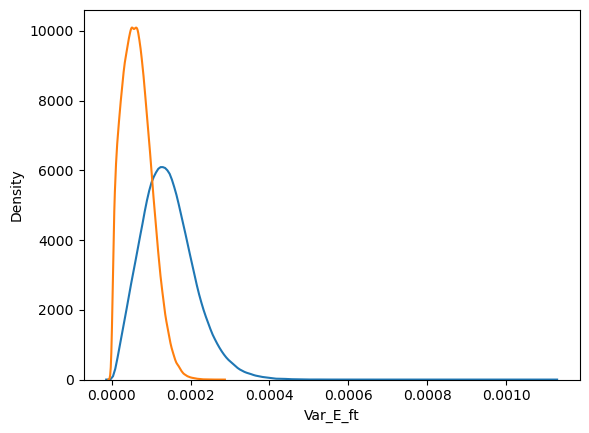

In [54]:
sns.kdeplot(result['Var_E_ft'])
sns.kdeplot(result['Var_I_ft'])

<Axes: xlabel='Var_E_sb', ylabel='Density'>

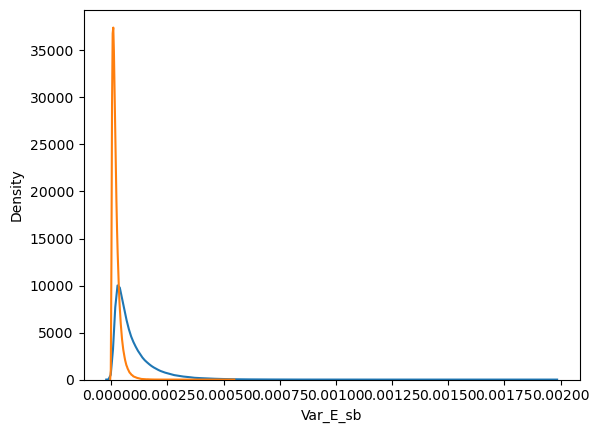

In [55]:
sns.kdeplot(result['Var_E_sb'])
sns.kdeplot(result['Var_I_sb'])

# **CI per text**

In [15]:
# get CI for each doc
records = {}

for doc, sims in doc_sim_dict.items():
    metrics = {}
    for model_key, model_label in [("ft", "ft"), ("sb", "sb")]:
        for sim_type in ["e", "i"]:
            key_prefix = f"{sim_type}_{model_key}"  # e_ft, i_ft, etc.
            scores = sims[f"{sim_type}_sim_{model_key}"]
            metrics[f"{key_prefix}_mean"] = np.mean(scores)
            metrics[f"{key_prefix}_std"] = np.std(scores)
            metrics[f"{key_prefix}_ci_lower"] = np.percentile(scores, 2.5)
            metrics[f"{key_prefix}_ci_upper"] = np.percentile(scores, 97.5)
    records[doc] = metrics

# Convert to DataFrame
summary_df = pd.DataFrame.from_dict(records, orient='index').reset_index()
summary_df = summary_df.rename(columns={"index": "doc_id"})
summary_df

,doc_id,e_ft_mean,e_ft_std,e_ft_ci_lower,e_ft_ci_upper,i_ft_mean,i_ft_std,i_ft_ci_lower,i_ft_ci_upper,e_sb_mean,e_sb_std,e_sb_ci_lower,e_sb_ci_upper,i_sb_mean,i_sb_std,i_sb_ci_lower,i_sb_ci_upper
0,gbb0hkf,0.290059,0.009653,0.275974,0.306600,0.300206,0.012008,0.285178,0.317847,0.095614,0.009835,0.082078,0.115392,0.085413,0.008298,0.071962,0.096476
1,gjyntrw,0.099778,0.009540,0.082055,0.121735,0.258231,0.004838,0.252598,0.263896,-0.197466,0.008876,-0.212554,-0.181786,-0.026073,0.001887,-0.027816,-0.022876
2,es83f0d,0.108921,0.007241,0.097853,0.123535,0.276078,0.004467,0.271205,0.281413,-0.152562,0.007737,-0.167422,-0.140977,0.085934,0.001741,0.083294,0.087726
3,g822s9b,0.448039,0.010676,0.434478,0.470485,0.459386,0.005011,0.453130,0.465258,0.123612,0.006439,0.111706,0.134573,0.136557,0.003383,0.130663,0.140617
4,cww24i6,0.284638,0.011513,0.269647,0.309534,0.285766,0.007869,0.277590,0.296727,-0.096966,0.008610,-0.115481,-0.081072,-0.092757,0.003030,-0.098112,-0.090112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
351943,j32scpd,0.293646,0.013762,0.275356,0.324280,0.338481,0.007924,0.330034,0.350890,-0.141939,0.005918,-0.155542,-0.131000,-0.077261,0.004317,-0.085786,-0.073055
351944,f82s6ji,0.194752,0.014522,0.172442,0.221840,0.058153,0.007700,0.050620,0.071092,-0.073703,0.013272,-0.091846,-0.051748,-0.223513,0.003072,-0.227114,-0.218394
351945,d5tqg57,0.329739,0.005366,0.320558,0.344094,0.354389,0.007807,0.346594,0.365974,0.128596,0.004875,0.118090,0.135730,0.206538,0.004565,0.202564,0.213555
351946,gb9zi8n,0.305476,0.011334,0.286734,0.332610,0.351733,0.009545,0.343274,0.367583,-0.090550,0.009380,-0.105255,-0.075398,-0.013355,0.003810,-0.019927,-0.008333


## **Check if true Similarity Scores is within CI**

In [14]:
subreddits = ["Ask_Politics", "Askpolitics", "PoliticalDebate", "PoliticalDiscussion", "NeutralPolitics", "politics"]

OG_texts_all = pd.DataFrame()

for subr in subreddits:

    if subr == "politics":
        
        df = pd.DataFrame()
        for i in range(1, 9):
            df_temp = pd.read_csv(f"output_non_clipped/politics_{i}_emb.csv")[['msg_id_parent', 'msg_id_child', 'submission_id', 
                                                                           'subreddit', 'finetuned_parent_E', 'finetuned_parent_I', 'finetuned_child_E',
                                                                           'finetuned_child_I', 'finetuned_submission_E', 'finetuned_submission_I',
                                                                           'self_parent_E', 'self_parent_I', 'self_child_E', 'self_child_I',
                                                                           'self_submission_E', 'self_submission_I']]
            df = pd.concat([df, df_temp]).reset_index(drop = True)
            print("Done with politics")

    else:
        df = pd.read_csv(f"output_non_clipped/{subr}_emb.csv")[['msg_id_parent', 'msg_id_child', 'submission_id', 'subreddit', 
                                                            'finetuned_parent_E', 'finetuned_parent_I', 'finetuned_child_E',
                                                            'finetuned_child_I', 'finetuned_submission_E', 'finetuned_submission_I',
                                                            'self_parent_E', 'self_parent_I', 'self_child_E', 'self_child_I',
                                                            'self_submission_E', 'self_submission_I']]
    
    
    comments_df = df[['subreddit', 'msg_id_parent', 'finetuned_parent_E', 'finetuned_parent_I', 
                      'self_parent_E','self_parent_I']].dropna().drop_duplicates().copy()
    comments_df.columns = ['subreddit', 'id', 'finetuned_E', 'finetuned_I', 'self_E', 'self_I']
    comments_df['type'] = 'parent'
    
    
    
    replies_df = df[['subreddit', 'msg_id_child', 'finetuned_child_E', 'finetuned_child_I', 
                      'self_child_E','self_child_I']].dropna().drop_duplicates().copy()
    replies_df.columns = ['subreddit', 'id', 'finetuned_E', 'finetuned_I', 'self_E', 'self_I']
    replies_df['type'] = 'child'
    
    subs_df = df[['subreddit', 'submission_id', 'finetuned_submission_E', 'finetuned_submission_I', 
                      'self_submission_E','self_submission_I']].dropna().drop_duplicates().copy()
    subs_df.columns = ['subreddit', 'id', 'finetuned_E', 'finetuned_I', 'self_E', 'self_I']
    subs_df['type'] = 'submission'
    
    # Concatenate into one unified dataframe
    OG_texts_df = pd.concat([comments_df, replies_df, subs_df], ignore_index=True)
    OG_texts_all = pd.concat([OG_texts_all, OG_texts_df]).reset_index(drop = True)
    
    
OG_texts_all

Done with politics
Done with politics
Done with politics
Done with politics
Done with politics
Done with politics
Done with politics
Done with politics


,subreddit,id,finetuned_E,finetuned_I,self_E,self_I,type
0,Ask_Politics,c7ecp8d,0.544985,0.502339,0.258746,0.135130,parent
1,Ask_Politics,c7efx8q,0.492762,0.461167,0.155293,0.091226,parent
2,Ask_Politics,c7edr13,0.420311,0.508084,0.132278,0.293948,parent
3,Ask_Politics,c7ee45j,0.367972,0.346008,0.220514,0.172562,parent
4,Ask_Politics,c7ejopx,0.115915,0.192232,0.072135,0.147608,parent
...,...,...,...,...,...,...,...
6804061,politics,z9t6wo,0.450341,0.539041,0.075379,0.235514,submission
6804062,politics,zaqhqs,0.450300,0.442575,0.093709,0.031933,submission
6804063,politics,zbjbu5,0.398775,0.361484,0.091835,0.034464,submission
6804064,politics,zdgyib,0.553811,0.496459,0.232695,0.105428,submission


In [16]:
OG_texts_all['id'].nunique() == len(OG_texts_all)


duplicate_ids = OG_texts_all['id'][OG_texts_all['id'].duplicated(keep=False)]
print(OG_texts_all[OG_texts_all['id'].isin(duplicate_ids)])


            subreddit       id  finetuned_E  finetuned_I    self_E    self_I  \
177      Ask_Politics  c7n1s7n     0.446825     0.371035  0.097441 -0.065448   
178      Ask_Politics  c7n1s7n     0.446825     0.371035  0.097441 -0.065448   
1081     Ask_Politics  c8t3m3f     0.407217     0.388348  0.021549 -0.056508   
1082     Ask_Politics  c8t3m3f     0.407217     0.388348  0.021549 -0.056508   
1559     Ask_Politics  c9eta88     0.334133     0.280392  0.043113 -0.032533   
...               ...      ...          ...          ...       ...       ...   
6803377      politics   kprd7i     0.441652     0.378029  0.080935 -0.075761   
6803401      politics   kwqdsf     0.322122     0.322666 -0.061069 -0.160825   
6803402      politics   kwqdsf     0.322122     0.322666 -0.061069 -0.160825   
6803586      politics   nbito7     0.551022     0.374590  0.309149 -0.036142   
6803587      politics   nbito7     0.551022     0.374590  0.309149 -0.036142   

               type  
177          pare

In [17]:
OG_texts_all = OG_texts_all.drop_duplicates(subset='id')


In [18]:
summary_df = summary_df.merge(OG_texts_all[['id', 'finetuned_E', 'finetuned_I', 'self_E', 'self_I']], left_on = "doc_id", right_on = "id", how = 'left')


In [19]:

def check_within_ci(row, og_val_col, ci_low_col, ci_up_col):
    og_val = row[og_val_col]
    return row[ci_low_col] <= og_val <= row[ci_up_col]

# Add boolean flags for each model-concept
summary_df["in_ci_i_ft"] = summary_df.apply(lambda row: check_within_ci(row, "finetuned_I", "i_ft_ci_lower", "i_ft_ci_upper"), axis=1)
summary_df["in_ci_e_ft"] = summary_df.apply(lambda row: check_within_ci(row, "finetuned_E", "e_ft_ci_lower", "e_ft_ci_upper"), axis=1)
summary_df["in_ci_i_sb"] = summary_df.apply(lambda row: check_within_ci(row, "self_I", "i_sb_ci_lower", "i_sb_ci_upper"), axis=1)
summary_df["in_ci_e_sb"] = summary_df.apply(lambda row: check_within_ci(row, "self_E", "e_sb_ci_lower", "e_sb_ci_upper"), axis=1)

In [20]:
summary_df.to_csv("output_bootstrapping/no_clipping_doc_in_CI.csv", index = False)

In [5]:
summary_df = pd.read_csv("output_bootstrapping/no_clipping_doc_in_CI.csv")

In [6]:
# Calculate shares
ci_results = {
    "ft_E": summary_df["in_ci_e_ft"].mean(),
    "ft_I": summary_df["in_ci_i_ft"].mean(),
    "sb_E": summary_df["in_ci_e_sb"].mean(),
    "sb_I": summary_df["in_ci_i_sb"].mean()
}

ci_results_df = pd.DataFrame.from_dict(ci_results, orient='index', columns=["share_in_CI"]).reset_index()
ci_results_df.rename(columns={"index": "model_concept"}, inplace=True)
ci_results_df

,model_concept,share_in_CI
0,ft_E,0.891717
1,ft_I,0.832418
2,sb_E,0.825406
3,sb_I,0.488811


In [7]:

ci_results_df[["model", "concept"]] = ci_results_df["model_concept"].str.split("_", expand=True)
ci_results_df

,model_concept,share_in_CI,model,concept
0,ft_E,0.891717,ft,E
1,ft_I,0.832418,ft,I
2,sb_E,0.825406,sb,E
3,sb_I,0.488811,sb,I


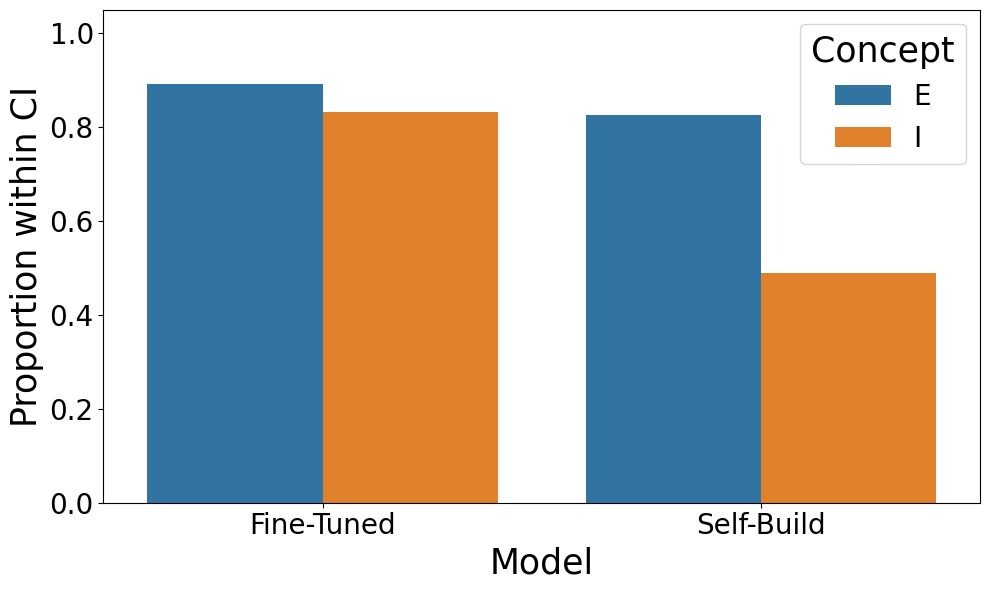

In [19]:
custom_palette = {
    "E": "#1F77B4",   # blue
    "I": "#FF7F0E"   # orange
}

label_map = {
    "ft": "Fine-Tuned",
    "sb": "Self-Build"
}


# Font settings
label_fontsize = 25
tick_fontsize = 20
title_fontsize = 12

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=ci_results_df,
    x="model",
    y="share_in_CI",
    hue="concept",
    palette=custom_palette
)

# Set custom x-tick labels
xticks = ax.get_xticks()
xticklabels = ax.get_xticklabels()
new_labels = [label_map.get(label.get_text(), label.get_text()) for label in xticklabels]
ax.set_xticks(xticks)
ax.set_xticklabels(new_labels, fontsize=tick_fontsize)

# Axis and plot styling
ax.set_ylim(0, 1.05)
#ax.axhline(0.95, color="gray", linestyle="--", linewidth=1, label="95% Reference")
ax.set_ylabel("Proportion within CI", fontsize=label_fontsize)
ax.set_xlabel("Model", fontsize=label_fontsize)
#ax.set_title("Share of True Similarity Scores within Bootstrapped 95% CI", fontsize=title_fontsize)

# Ticks
ax.tick_params(axis='y', labelsize=tick_fontsize)

# Legend
legend = ax.legend(title="Concept", fontsize=tick_fontsize, title_fontsize=label_fontsize)
#legend.get_frame().set_linewidth(0.5) 

plt.tight_layout()
plt.savefig("output_bootstrapping/no_clipping_doc_shares_plot.pdf")
plt.show()